In [77]:
import tensorflow as tf
import keras
import keras_tuner as kt
import sqlite3
import random
import imghdr
from pandas import DataFrame as df

## Getting the data
Our data is stored in a SQlite database. We will use the `sqlite3` library to interact with the database.

### Load data from database

In [82]:
# Open db connection
conn = sqlite3.connect("testDB.db")
cursor = conn.cursor()

In [83]:
# Get results from db
cursor.execute(f"SELECT path, price FROM Dish WHERE price >= 10 AND price NOT LIKE '%+%'")
items = cursor.fetchall()

# Shuffle items
random.shuffle(items)

In [84]:
# Close db connection
cursor.close()
conn.close()

In [127]:
# Convert to pandas dataframe
items = df(items, columns=["path", "price"])
items

,path,price
0,Images!/44.jpg,12.49
1,Images!/1891.jpg,14.00
2,Images!/1959.jpg,16.00
3,Images!/2426.png,12.99
4,Images!/2439.jpg,21.99
...,...,...
1715,Images!/2016.jpg,65.00
1716,Images!/2419.png,17.99
1717,Images!/3022.jpg,38.00
1718,Images!/3346.jpg,32.50


In [128]:
# Remove rows where file is type TF can't read
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"] # https://stackoverflow.com/a/68192520
items = items[items["path"].apply(lambda x: imghdr.what(x) in img_type_accepted_by_tf)]
items

,path,price
0,Images!/44.jpg,12.49
1,Images!/1891.jpg,14.00
2,Images!/1959.jpg,16.00
3,Images!/2426.png,12.99
4,Images!/2439.jpg,21.99
...,...,...
1715,Images!/2016.jpg,65.00
1716,Images!/2419.png,17.99
1717,Images!/3022.jpg,38.00
1718,Images!/3346.jpg,32.50


### Create dataset
Now that we have the data from the database, we will create a dataset that we can use to train our model. This dataset will consist of the following columns:
- `path`: The path to the image file, which will be our feature
- `price`: The price of the image, which will be our target variable

In [129]:
# https://stackoverflow.com/a/75288145
def load_image(file_name):
    raw = tf.io.read_file(file_name)
    tensor = tf.io.decode_image(raw, expand_animations = False, channels = 3)
    tensor = tf.cast(tensor, tf.float32)
    return tensor

def create_dataset(file_names, labels):
    dataset = tf.data.Dataset.from_tensor_slices((file_names, labels))
    dataset = dataset.map(lambda file_name, label: (load_image(file_name), label))
    return dataset

file_names = items['path'].to_numpy()
labels = items['price'].to_numpy()
dataset = create_dataset(file_names, labels)
dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

### Data splitting
We will split our data into training and testing sets. We will use 80% of the data for training and 20% for testing. We'll use 20% of the training data for validation, the remaining 80% will be used for training.

In [130]:
# Split the data into training (80%) and test (20%), then split training into training (80%) and validation (20%) of the training data
dataset.shuffle(dataset.cardinality())
test_prices = dataset.take(dataset.cardinality() // 5)
train_prices = dataset.skip(dataset.cardinality() // 5)
val_prices = train_prices.take(train_prices.cardinality() // 5)
train_prices = train_prices.skip(train_prices.cardinality() // 5)

test_prices.cardinality(), val_prices.cardinality(), train_prices.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=343>,
 <tf.Tensor: shape=(), dtype=int64, numpy=275>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1101>)

In [131]:
# Reshape images
image_dim = 256
size = (image_dim, image_dim)
train_ds = train_prices.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = val_prices.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_prices.map(lambda x, y: (tf.image.resize(x, size), y))

train_ds.cardinality(), validation_ds.cardinality(), test_ds.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=1101>,
 <tf.Tensor: shape=(), dtype=int64, numpy=275>,
 <tf.Tensor: shape=(), dtype=int64, numpy=343>)

In [132]:
# We'll also setup prefetching so that we can more easily load the data for training/testing
batch_size = 16
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

train_ds.cardinality(), validation_ds.cardinality(), test_ds.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=69>,
 <tf.Tensor: shape=(), dtype=int64, numpy=18>,
 <tf.Tensor: shape=(), dtype=int64, numpy=22>)

### Building the model
We'll load the Xception model trained on Imagenet data. However we'll explicity drop the fully connected layers so we can add our own (seen in the `include_top=False` line). Then, we'll add our own fully connected layers to the model. Then, we'll use hyperparameter optimization to find the best hyperparameters for the model. Finally, we'll train the model on the data.

In [135]:
def price_model(hp):
    # From Keras we load the Xception model
    base_model = keras.applications.Xception(
        weights="imagenet",  # load the model with weights from training on ImageNet
        input_shape=(image_dim, image_dim, 3), 
        include_top=False, # This states we won't include the "top" layers (the classifier)
    )

    # We can freeze the weights of any model/layer so they won't be updated when training the model
    base_model.trainable = False

    # With the base model defined we can create a regular Keras sequential model
    inputs = keras.Input(shape=(image_dim, image_dim, 3))
    # This version of the Xception model expects inputs to be scaled from (0, 255) to a range of (-1., +1.)
    scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
    x = scale_layer(inputs)

    # The base model contains batchnorm layers, by setting training=False here it'll prevent those from being modified
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)

    hp_units_1 = hp.Int('units_1', min_value=60, max_value=256, step=20)
    x = keras.layers.Dense(hp_units_1, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.MeanSquaredError(),
    )

    return model

In [136]:
model = kt.Hyperband(price_model,
                     objective='val_loss',
                     max_epochs=15,
                     factor=3,
                     seed=10,
                     directory='hpm',
                     project_name='eatable_model',
                     overwrite=True)

model.search(train_ds, validation_data=validation_ds)

best_hps = model.get_best_hyperparameters(num_trials=1)[0]
model = model.hypermodel.build(best_hps)
model.summary()

Trial 30 Complete [00h 03m 22s]
val_mean_squared_error: 1458.3741455078125

Best val_mean_squared_error So Far: 1428.239013671875
Total elapsed time: 00h 57m 52s
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                             

In [137]:
epochs = 5
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/5
69/69 [==============================] - 27s 309ms/step - loss: 841.5084 - mean_squared_error: 841.5084 - val_loss: 2156.1523 - val_mean_squared_error: 2156.1523
Epoch 2/5
69/69 [==============================] - 14s 192ms/step - loss: 686.4072 - mean_squared_error: 686.4072 - val_loss: 2000.6801 - val_mean_squared_error: 2000.6801
Epoch 3/5
69/69 [==============================] - 13s 187ms/step - loss: 583.3390 - mean_squared_error: 583.3390 - val_loss: 1836.0377 - val_mean_squared_error: 1836.0377
Epoch 4/5
69/69 [==============================] - 13s 182ms/step - loss: 485.2166 - mean_squared_error: 485.2166 - val_loss: 1705.0035 - val_mean_squared_error: 1705.0035
Epoch 5/5
69/69 [==============================] - 13s 185ms/step - loss: 446.5698 - mean_squared_error: 446.5698 - val_loss: 1685.7227 - val_mean_squared_error: 1685.7227


1/1 [==============================] - 0s 146ms/step


/var/folders/l4/p__14z5x5rl4rjxvfwyqm1z00000gn/T/ipykernel_3405/2173343017.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Actual: {(labels[iy])}\nPredicted: {round(float(model_labels[iy]), 2)}")


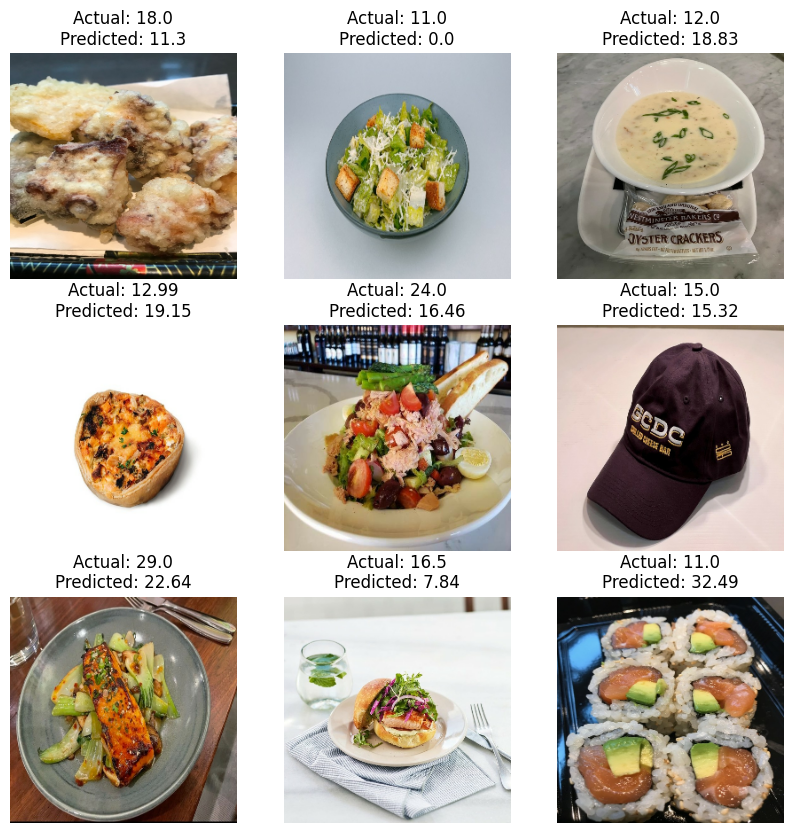

In [147]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for ix, (images, labels) in enumerate(train_ds.take(1)):
    model_preds = model.predict(images)
    model_labels = np.where(model_preds>0, model_preds, 0)
    for iy in range(9):
        ax = plt.subplot(3, 3, iy + 1)
        plt.imshow(np.array(images[iy]).astype(int))
        plt.title(f"Actual: {(labels[iy])}\nPredicted: {round(float(model_labels[iy]), 2)}")
        plt.axis("off")

# Save the model

In [141]:
model.save("eatable_model_reg")

INFO:tensorflow:Assets written to: eatable_model_reg/assets


INFO:tensorflow:Assets written to: eatable_model_reg/assets
